In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
path = 'data/archive/Abstract_gallery'
os.path.exists(path)

True

In [3]:
image_size = (64, 64)
dataset = datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               # normalize to the range [-1, 1]
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

batch_size = 64
# create a dataloader 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [4]:
transform = transforms.ToTensor()
dataset2 = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, drop_last=True)


In [5]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break


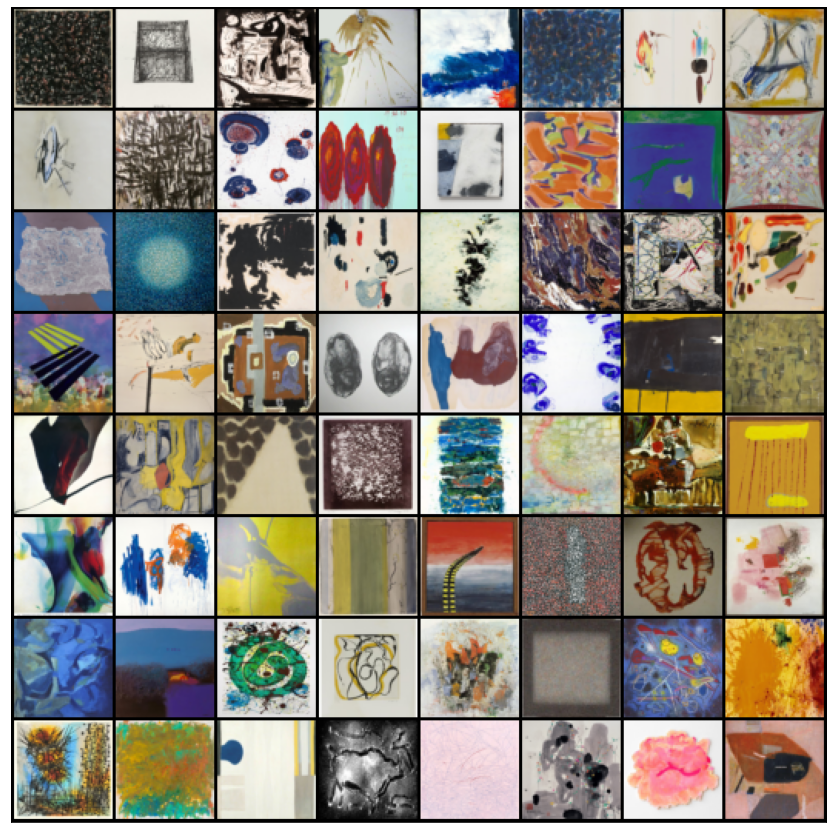

In [6]:
show_batch(dataloader)

In [7]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


n_epochs = 5
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 1
latent_dim = 100
img_size = 64
channels = 3
sample_interval = 400


img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------
import time
start = time.time()
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        #if batches_done % sample_interval == 0:
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    now = time.time()
    # get the execution time
    elapsed_time = now - start
    print('Elapsed time:', elapsed_time, 'seconds')

[Epoch 0/5] [Batch 0/44] [D loss: 0.699735] [G loss: 0.673964]
[Epoch 0/5] [Batch 1/44] [D loss: 0.627004] [G loss: 0.669389]
[Epoch 0/5] [Batch 2/44] [D loss: 0.518561] [G loss: 0.664598]
[Epoch 0/5] [Batch 3/44] [D loss: 0.471720] [G loss: 0.660565]
[Epoch 0/5] [Batch 4/44] [D loss: 0.432660] [G loss: 0.655221]
[Epoch 0/5] [Batch 5/44] [D loss: 0.415876] [G loss: 0.654243]
[Epoch 0/5] [Batch 6/44] [D loss: 0.403989] [G loss: 0.653760]
[Epoch 0/5] [Batch 7/44] [D loss: 0.401760] [G loss: 0.660167]
[Epoch 0/5] [Batch 8/44] [D loss: 0.390925] [G loss: 0.667198]
[Epoch 0/5] [Batch 9/44] [D loss: 0.380296] [G loss: 0.673851]
[Epoch 0/5] [Batch 10/44] [D loss: 0.378669] [G loss: 0.685019]
[Epoch 0/5] [Batch 11/44] [D loss: 0.371981] [G loss: 0.700548]
[Epoch 0/5] [Batch 12/44] [D loss: 0.356452] [G loss: 0.717441]
[Epoch 0/5] [Batch 13/44] [D loss: 0.351361] [G loss: 0.736882]
[Epoch 0/5] [Batch 14/44] [D loss: 0.363333] [G loss: 0.752894]
[Epoch 0/5] [Batch 15/44] [D loss: 0.340011] [G lo